In [1]:
import igraph as ig
import pandas as pd
import matplotlib.cm as cm


/home/victor/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_68966/3484835087.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# Carregando a matriz de adjacências e fazendo as devidas adaptações
matriz_adj = pd.read_csv('matriz_adj_final.csv', index_col='Aluno')
matriz_adj = matriz_adj.replace(',', '.', regex=True)
matriz_adj = matriz_adj.astype(float)
# Convertendo a matriz para um array numpy
adj_array = matriz_adj.values


In [3]:
# Criando o grafo a partir da matriz de adjacências
grafo = ig.Graph.Adjacency((adj_array > 0).tolist(), mode=ig.ADJ_UPPER)

# Adicionando os pesos às arestas
grafo.es['weight'] = adj_array[adj_array.nonzero()]

# Encontrar o peso máximo considerando os pesos invertidos
peso_max = max(grafo.es['weight'])

# Criar um subgrafo com arestas que têm 70% ou mais do peso máximo invertido
sub_g = grafo.subgraph_edges(grafo.es.select(weight_ge=peso_max * 0.70), delete_vertices=False)

In [4]:

greedy = sub_g.community_fastgreedy(weights='weight')
comunidades = greedy.as_clustering()

# Adicionar as comunidades ao grafo
sub_g.vs['comunidade'] = comunidades.membership

In [5]:
# Adicionar as cores de acordo com as comunidades
cores = cm.tab20b.colors
sub_g.vs['cor'] = [cores[com % len(cores)] for com in sub_g.vs['comunidade']]
sub_g.vs['size'] = 10

In [6]:
# Ajustar as coordenadas para agrupar os vértices da mesma comunidade
num_comunidades = len(set(sub_g.vs['comunidade']))

In [7]:
# Exibir informações sobre o subgrafo
print(f'Número de vértices no subgrafo: {len(sub_g.vs)}')
print(f'Número de arestas no subgrafo: {len(sub_g.es)}')
print(f'Número de comunidades detectadas: {num_comunidades}')

with open("greedy.txt", "w") as f:
    for comunidade in range(num_comunidades):
        vertices = [v.index for v in sub_g.vs if v['comunidade'] == comunidade]
        f.write(f"Comunidade {comunidade}:\n")
        f.write(", ".join(map(str, vertices)) + "\n\n")


Número de vértices no subgrafo: 961
Número de arestas no subgrafo: 1549
Número de comunidades detectadas: 110


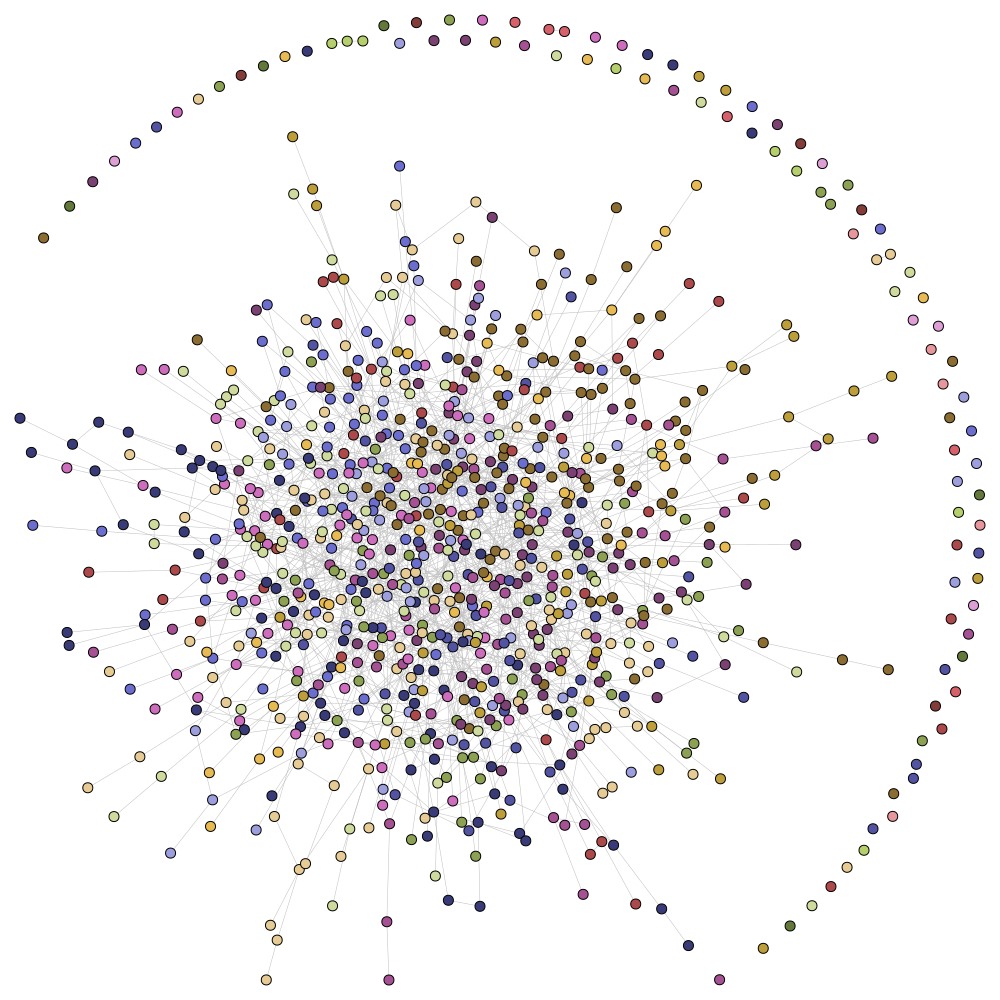

In [8]:
# Plotando o grafo
ig.plot(sub_g, 'greedy.png', vertex_size=10, vertex_color=sub_g.vs['cor'], edge_width=0.5, edge_color='gray',mark_groups=True, bbox=(0, 0, 1000, 1000))